In [1]:
# Import libraries and packages
import os
import pandas as pd
import numpy as np

# Define path with .py codes containing functions used in this script
os.getcwd()
os.chdir( '../src/features')

# Import useful functions for this script  
from tracking import track
import matplotlib.pyplot as plt

# Reading data
#### Define path to data files

In [2]:
track("Defining path to data files")

# Define base path to data files
path1 = '../../data/raw/'
path2 = '../../temp_data/'

# Define path to the jira issues table
# path_git_commits = path1 + 'GIT_COMMITS.csv'
# path_jira_issues = path1 + 'JIRA_ISSUES.csv'
path_clusters_data = path2 + 'model_data_with_clusters.csv'

# Ensure the input file exist
# assert os.path.isfile(path_git_commits), f'{path_git_commits} not found. Is it a file?'
# assert os.path.isfile(path_jira_issues), f'{path_jira_issues} not found. Is it a file?'
assert os.path.isfile(path_clusters_data), f'{path_clusters_data} not found. Is it a file?'

#### Read the files

In [3]:
track("Reading files")

# Read GIT_COMMITS, JIRA_ISSUES, and clusterized data 
clusterized_data = pd.read_csv(path_clusters_data)

track("Finished reading files")

# Validation

In [4]:
average_quality = (clusterized_data.groupby('clusters').agg(blocker_violations_mean = ('blocker_violations', 'mean'),
                                          blocker_violations_std = ('blocker_violations', 'std'),
                                          critical_violations_mean = ('critical_violations', 'mean'),
                                          critical_violations_std = ('critical_violations', 'std'),
                                          major_violations_mean = ('major_violations', 'mean'),
                                          major_violations_std = ('major_violations', 'std'),
                                          minor_violations_mean = ('minor_violations', 'mean'),
                                          minor_violations_std = ('minor_violations', 'std'),
                                          code_smells_mean = ('code_smells', 'mean'),
                                          code_smells_std = ('code_smells', 'std'),
                                          bugs_mean = ('bugs', 'mean'),
                                          bugs_std = ('bugs', 'std'),
                                          vulnerabilities_mean = ('vulnerabilities', 'mean'),
                                          vulnerabilities_std = ('vulnerabilities', 'std'),
                                          sqale_debt_ratio_mean = ('sqale_debt_ratio', 'mean'),
                                          sqale_debt_ratio_std = ('sqale_debt_ratio', 'std'),
                                          blocker_mean = ('blocker', 'mean'),
                                          blocker_std = ('blocker', 'std'),
                                          critical_mean = ('critical', 'mean'),
                                          critical_std = ('critical', 'std'),
                                          major_mean = ('major', 'mean'),
                                          major_std = ('major', 'std'),
                                          minor_mean = ('minor', 'mean'),
                                          minor_std = ('minor', 'std'))).reset_index()

In [5]:
FONTSIZE = 30
FIG_WIDTH = 38
FIG_HEIGHT = 15

In [6]:
def plot_quality_metrics(df,metrics):
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    for metric in metrics:
        markers, caps, bars = plt.errorbar(range(len(df)), df[metric + '_mean'], df[metric + '_std'],
                                        label=metric,  fmt='--o', markersize=15, elinewidth=6)
        [bar.set_alpha(0.4) for bar in bars]
        [cap.set_alpha(0.4) for cap in caps]

    plt.title('Quality of each cluster', fontsize = FONTSIZE)
    plt.xlabel('Cluster', fontsize = FONTSIZE)
    plt.ylabel('Metric value', fontsize = FONTSIZE)
    plt.xticks(ticks=range(len(df)), labels=df["clusters"], fontsize = FONTSIZE)
    #plt.yticks(ticks = [-.4,-.2, 0,.2, .4, .6, .8,1.], fontsize=FONTSIZE)
    plt.legend(metrics, bbox_to_anchor=(1.001,0.8), prop={'size': FONTSIZE})
    plt.grid()
    #plt.savefig('./output/Height/r2_height',  bbox_inches='tight')
    plt.show()
    plt.close()

In [7]:
violation_metrics = ["blocker_violations", "critical_violations", "major_violations", "minor_violations"]
severity_metrics = ["blocker", "critical", "major", "minor"]
other_metrics = ["code_smells", "bugs", "vulnerabilities", "sqale_debt_ratio"]

In [8]:
def order_table(df,metrics):
    ordered = df.copy()
    # Creation of a new column that will contain the sum of the metrics.
    sum_metrics = [0 for i in range(len(df))] # Equal to num clusters.
    for i, row in  ordered.iterrows():
        for metric in metrics:
            sum_metrics[i]+= row[metric+"_mean"]
    ordered["sum_metrics"] = sum_metrics
    return ordered.sort_values(by=['sum_metrics'],ascending = False)

In [9]:
ordered = order_table(average_quality,violation_metrics)

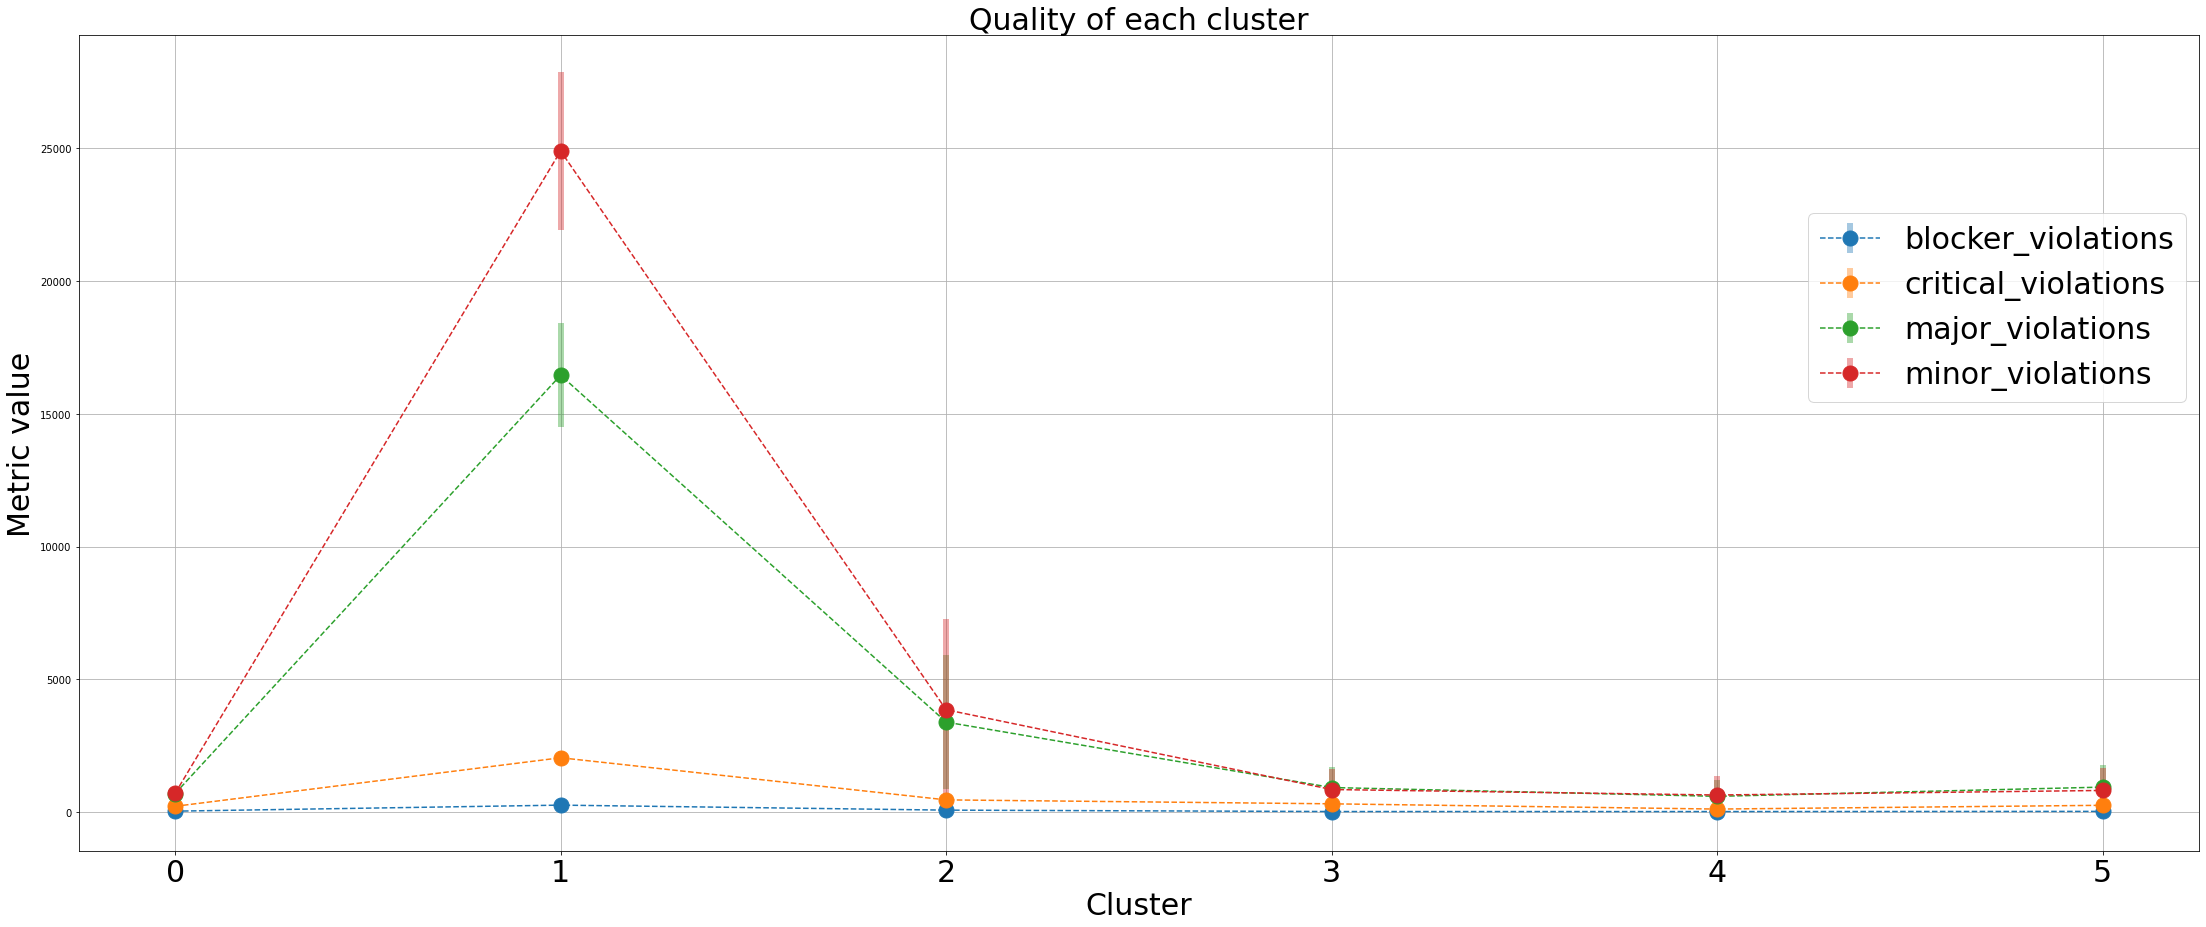

In [10]:
plot_quality_metrics(average_quality,violation_metrics)

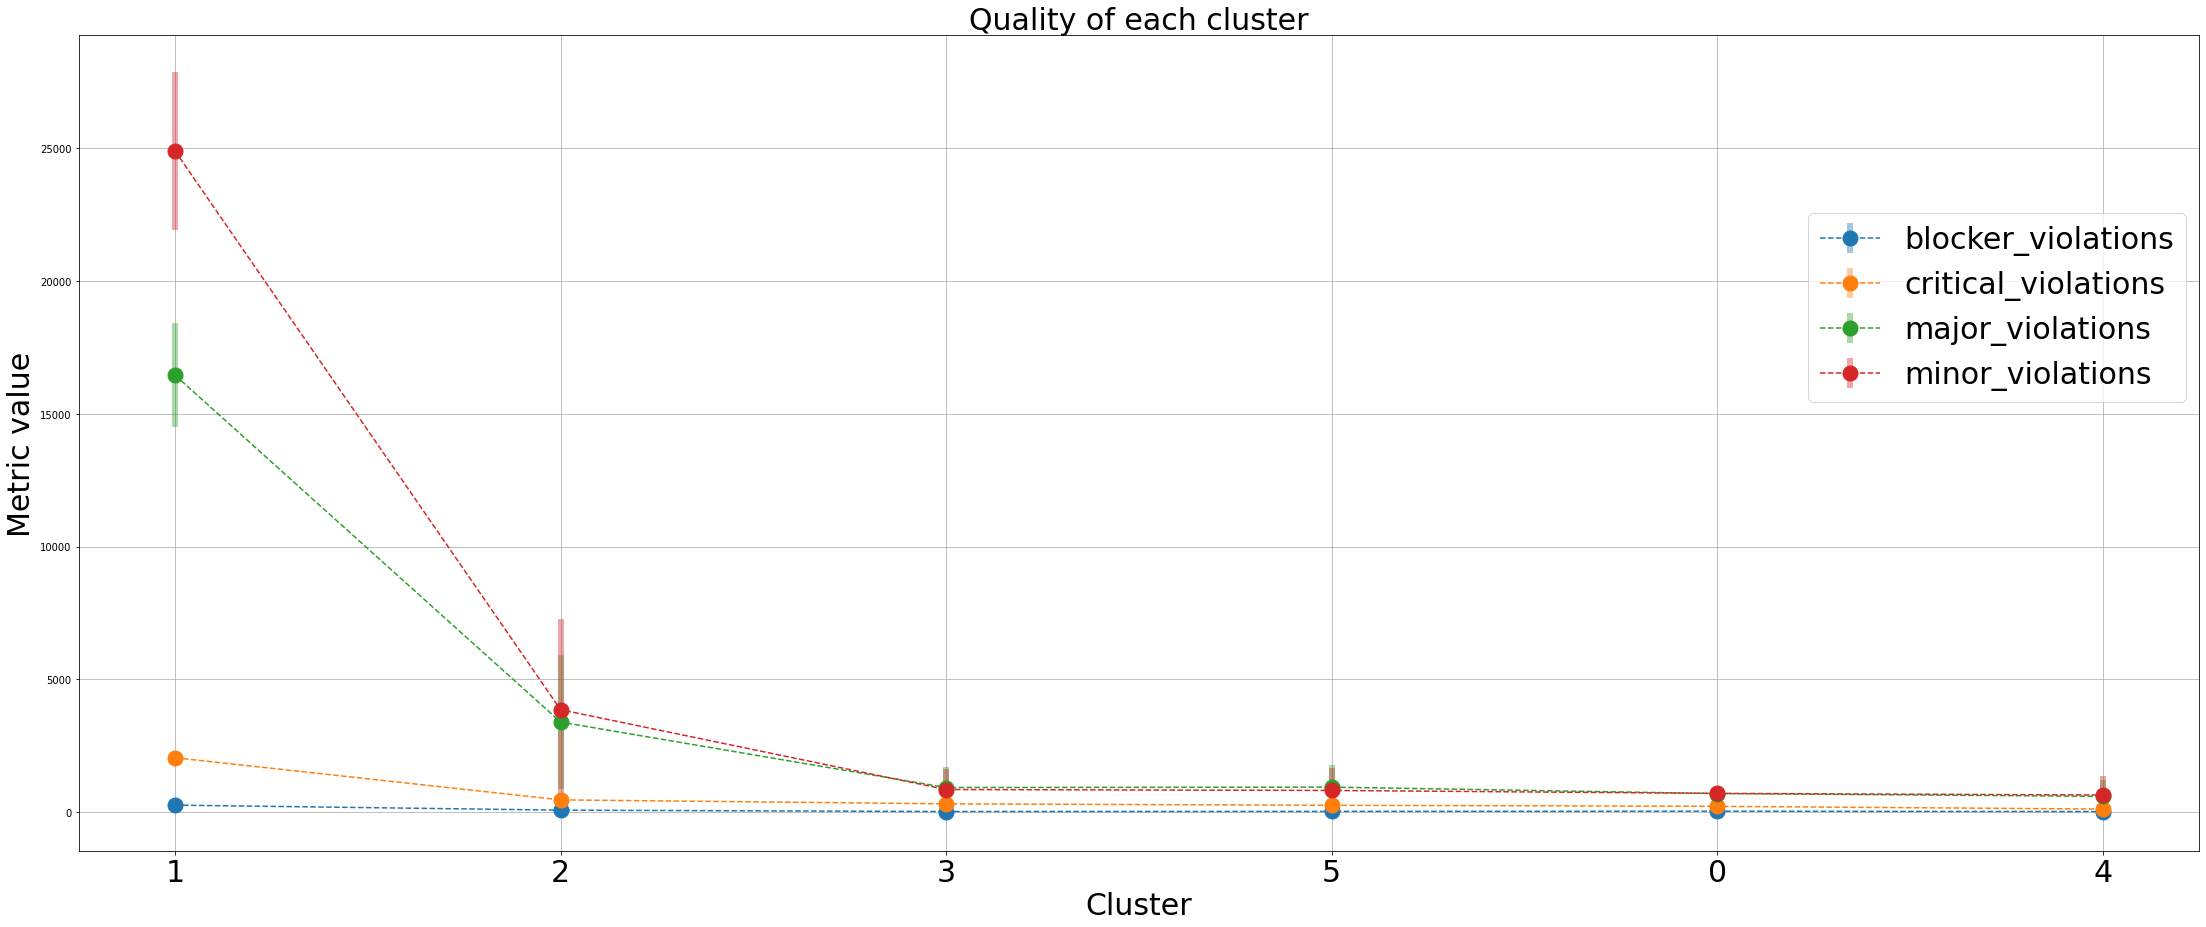

In [11]:
plot_quality_metrics(ordered,violation_metrics)

In [12]:
ordered2 = order_table(average_quality,severity_metrics)

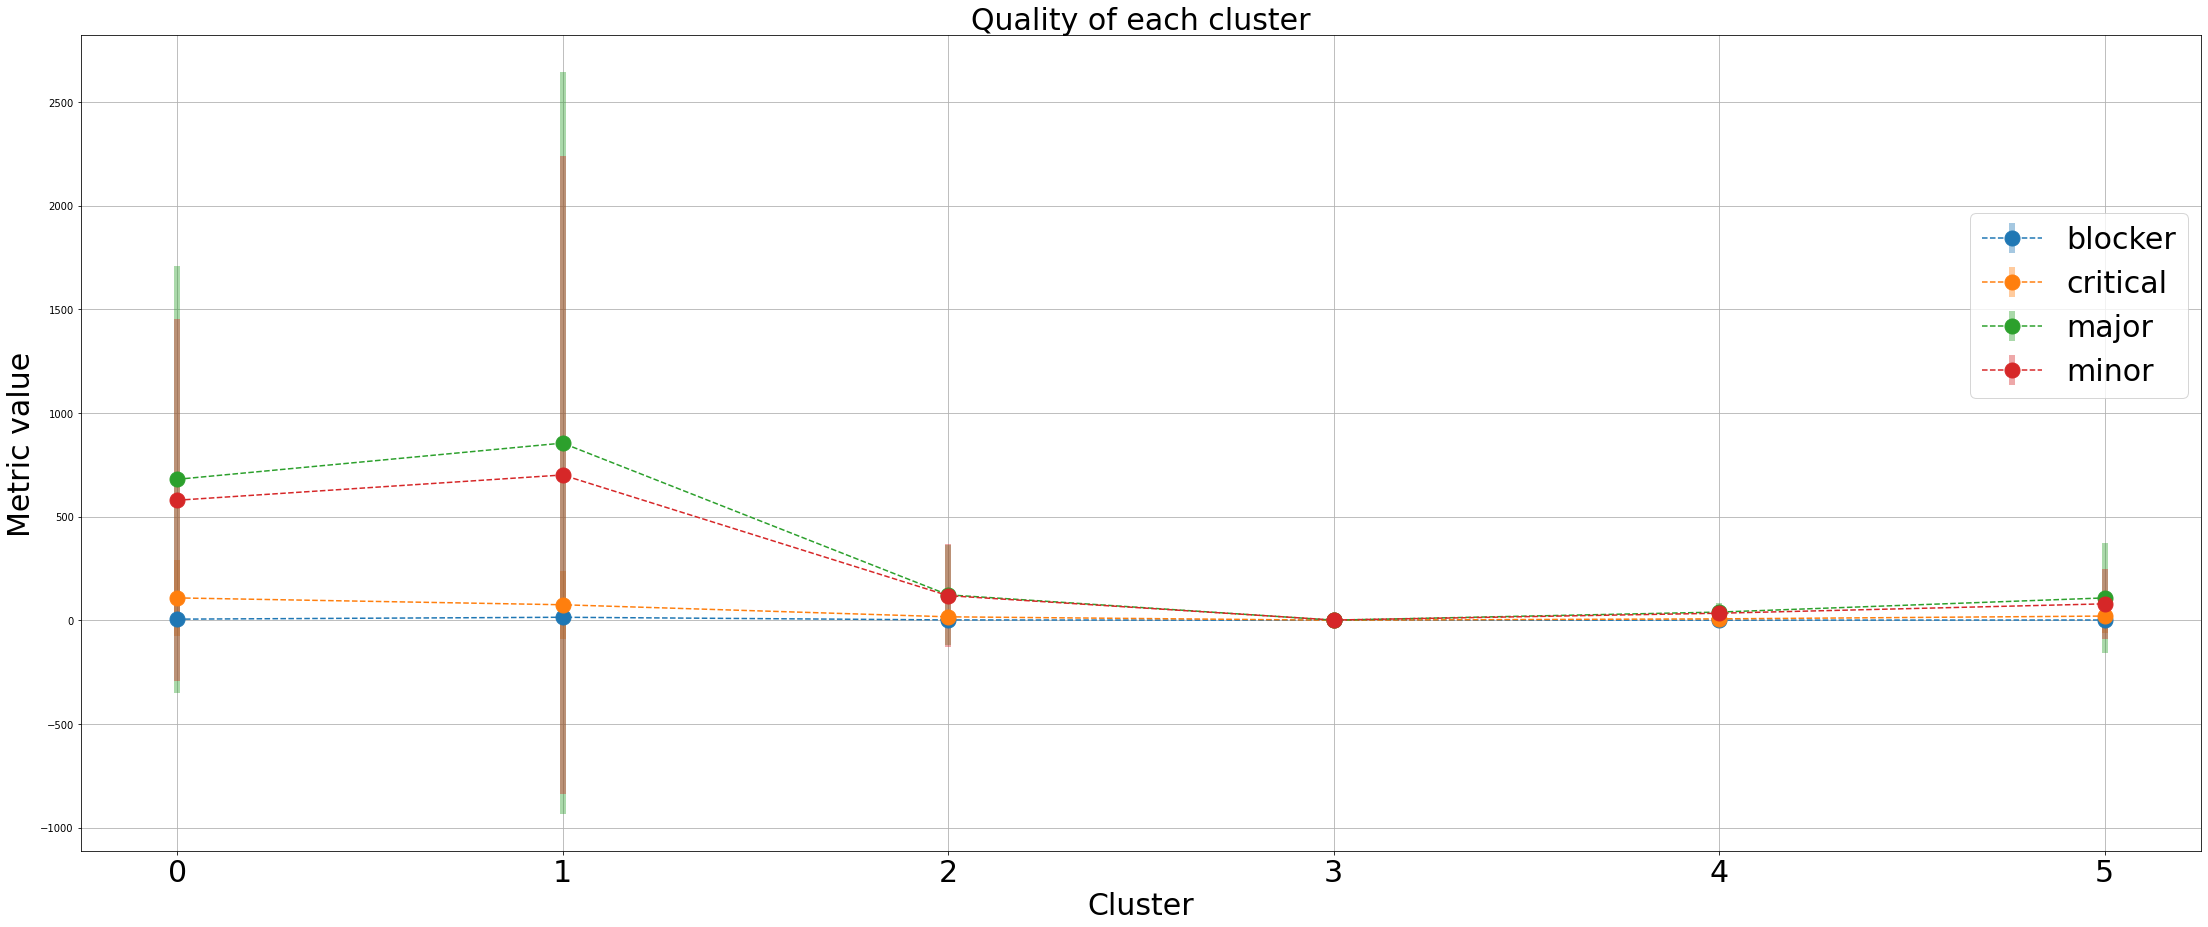

In [13]:
plot_quality_metrics(average_quality,severity_metrics)

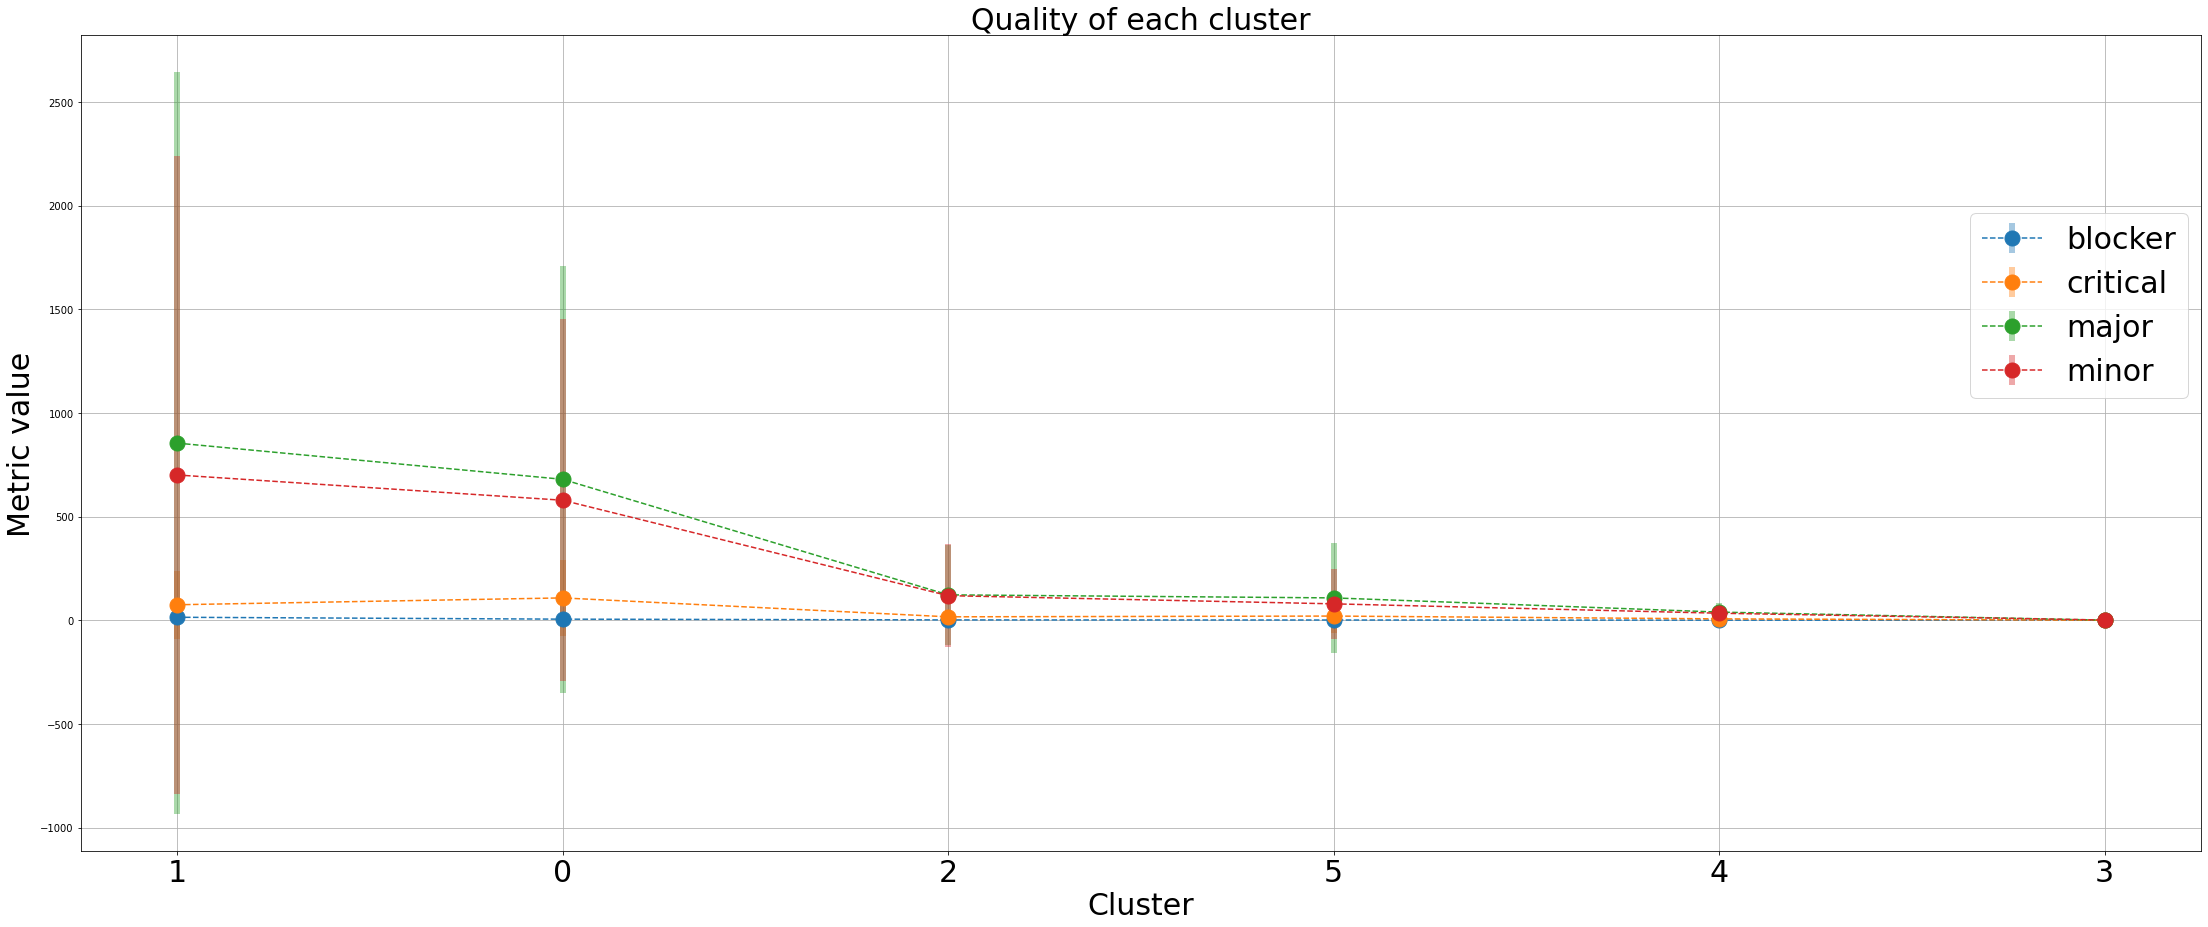

In [14]:
plot_quality_metrics(ordered2,severity_metrics)

In [15]:
ordered3 = order_table(average_quality,other_metrics)

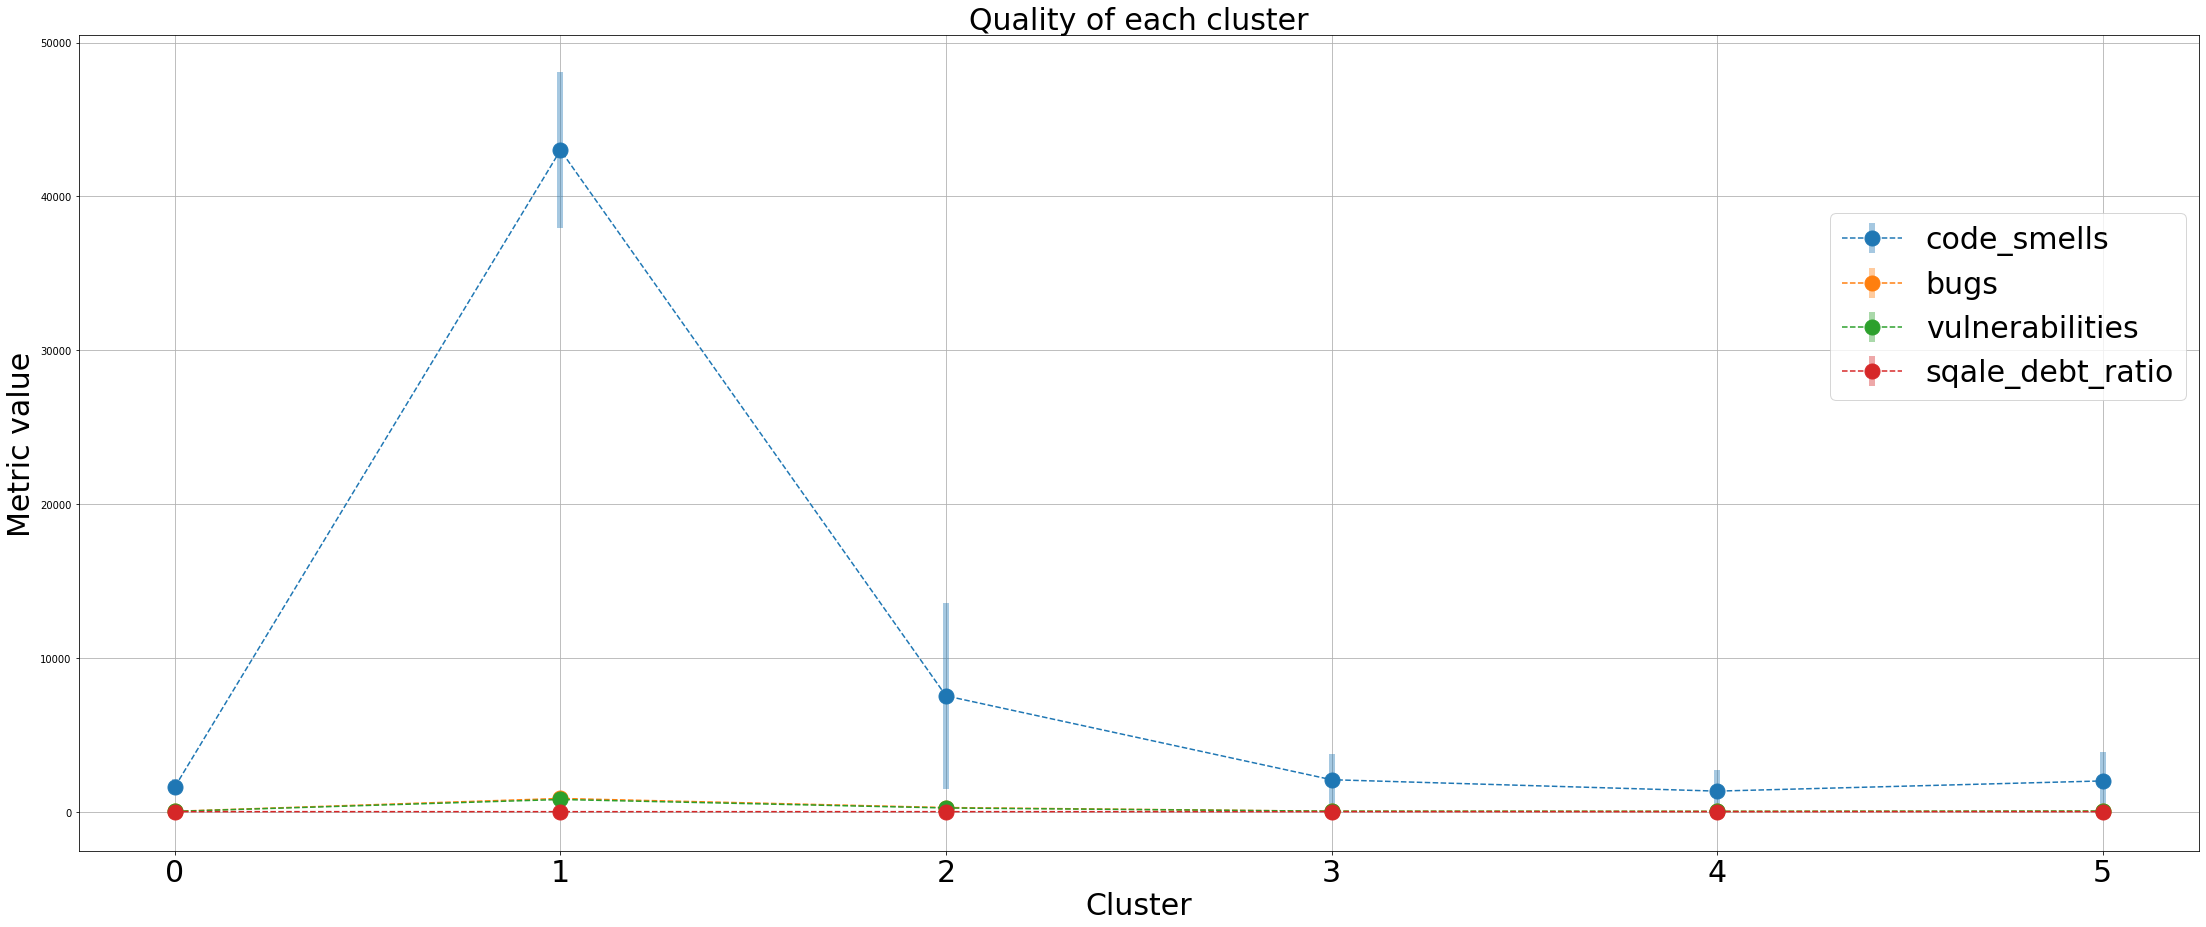

In [16]:
plot_quality_metrics(average_quality,other_metrics)

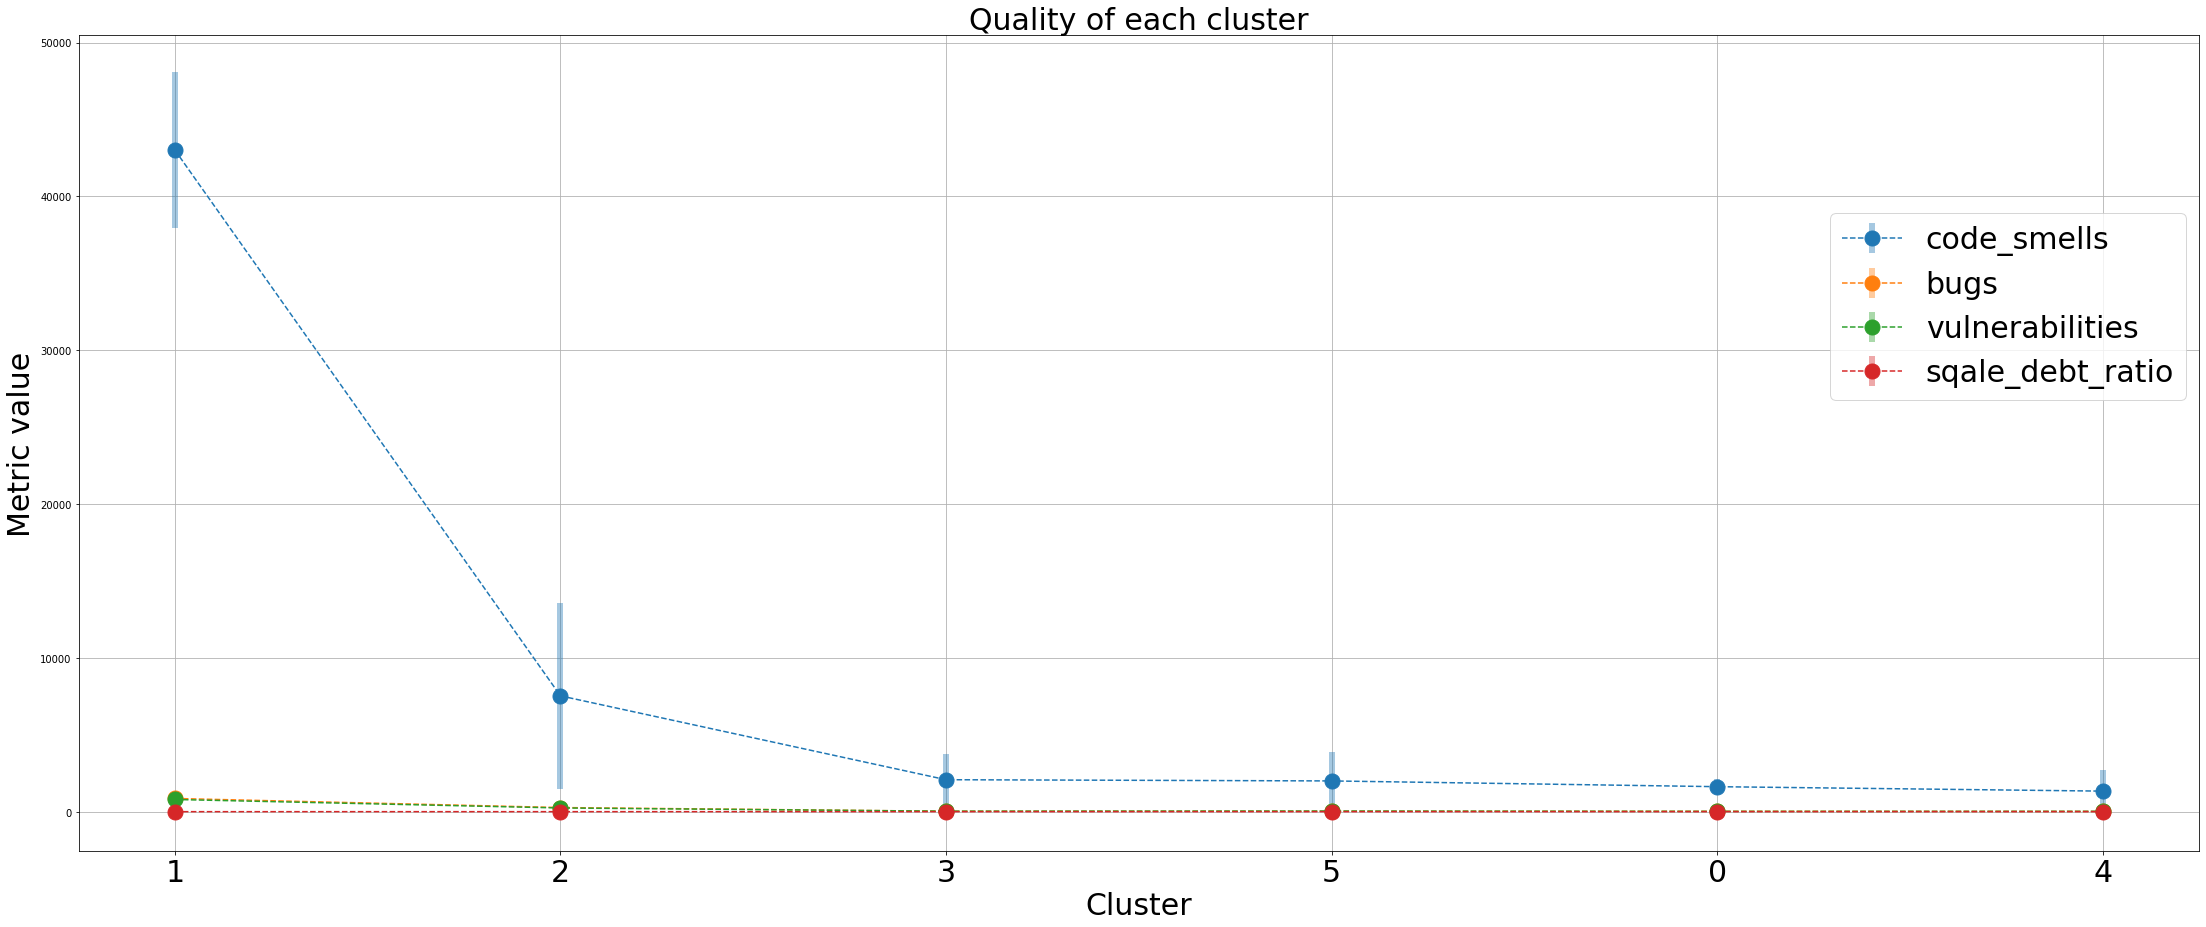

In [17]:
plot_quality_metrics(ordered3,other_metrics)

# Creation of quality index.

In [20]:
# Hay que mirar si normalizamos y como invertir las que cuanto mas bajo mejor.
quality_rating_data = clusterized_data.groupby('clusters').agg({
    'violations': 'sum',
                            'blocker_violations': 'sum',
                            'critical_violations': 'sum',
                            'major_violations': 'sum',
                            'minor_violations': 'sum',
                            'blocker': 'sum',
                            'critical': 'sum',
                            'major': 'sum',
                            'minor': 'sum',
                            'code_smells': 'sum',
                            'bugs': 'sum',
                            'vulnerabilities': 'sum',
                            'sqale_debt_ratio': 'mean',
}).reset_index()
quality_rating_data.head()

,clusters,violations,blocker_violations,critical_violations,major_violations,minor_violations,blocker,critical,major,minor,code_smells,bugs,vulnerabilities,sqale_debt_ratio
0,0,5.195543e+04,942.905569,6597.253534,21491.919730,21725.246718,164.0,3342.0,21073.0,17945.0,5.045322e+04,863.729027,638.480194,4.223650
1,1,1.161369e+06,6701.945686,53107.271067,427847.447809,647465.776116,375.0,1944.0,22215.0,18218.0,1.118317e+06,22402.814745,20649.358217,3.217348
2,2,3.781679e+05,3241.243261,21409.385908,159141.240262,181085.159289,78.0,779.0,5760.0,5576.0,3.540265e+05,12728.503257,11412.854517,3.655210
3,3,7.505924e+04,579.421429,10748.547619,32221.585714,29592.225000,0.0,6.0,17.0,37.0,7.281237e+04,1049.216667,1197.652381,3.742374
4,4,4.427872e+04,495.022498,3486.926640,18850.481445,20455.363259,17.0,215.0,1261.0,1085.0,4.283693e+04,684.899245,756.896068,5.434847



- 1. divide each type of violation by the total number of violations of that type to have the proportion for each violation metric and the same for the issues. For the sqale_debt_ratio, it is divided by 100 and reverse it (1-sdr)

In [21]:
sdr = quality_rating_data["sqale_debt_ratio"]
sdr = sdr/100
sdr

0    0.042237
1    0.032173
2    0.036552
3    0.037424
4    0.054348
5    0.039285
Name: sqale_debt_ratio, dtype: float64

Calculate the total number of each type

In [22]:
quality_rating_normalized = quality_rating_data[["blocker_violations", "critical_violations", "major_violations", "minor_violations","blocker", "critical", "major", "minor","code_smells", "bugs", "vulnerabilities"]]
total = quality_rating_normalized.sum(axis=0)
total

blocker_violations     1.357835e+04
critical_violations    1.136808e+05
major_violations       7.279131e+05
minor_violations       9.595091e+05
blocker                7.200000e+02
critical               7.761000e+03
major                  5.819700e+04
minor                  4.864000e+04
code_smells            1.784544e+06
bugs                   4.005276e+04
vulnerabilities        3.780566e+04
dtype: float64

In [23]:
quality_rating_normalized = quality_rating_normalized/total
quality_rating_normalized.head()

,blocker_violations,critical_violations,major_violations,minor_violations,blocker,critical,major,minor,code_smells,bugs,vulnerabilities
0,0.069442,0.058033,0.029525,0.022642,0.227778,0.430615,0.362098,0.368935,0.028272,0.021565,0.016888
1,0.493576,0.467161,0.587773,0.674789,0.520833,0.250483,0.381721,0.374548,0.626668,0.559333,0.546198
2,0.238707,0.188329,0.218627,0.188727,0.108333,0.100374,0.098974,0.114638,0.198385,0.317793,0.301882
3,0.042672,0.094550,0.044266,0.030841,0.000000,0.000773,0.000292,0.000761,0.040802,0.026196,0.031679
4,0.036457,0.030673,0.025897,0.021319,0.023611,0.027703,0.021668,0.022307,0.024004,0.017100,0.020021


Ponderation of each metric:
- 'blocker_violations': '0.9',
- 'critical_violations': '0.8',
- 'major_violations': '0.7',
- 'minor_violations': '0.6',
- 'blocker': '0.4',
- 'critical': '0.3',
- 'major': '0.2',
- 'minor': '0.1',
- 'code_smells': '1',
- 'bugs': '1',
- 'vulnerabilities': '1',

ELS ÚTIMS TRES NOSÉ QUIN PESA MENYS O MÉS I SI HO VOLEU DEIXAR TAL QUAL

In [24]:
ponderations = [0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1,1,1,1]
quality_rating_normalized_pondered = quality_rating_normalized*ponderations
quality_rating_normalized_pondered

,blocker_violations,critical_violations,major_violations,minor_violations,blocker,critical,major,minor,code_smells,bugs,vulnerabilities
0,0.062498,0.046427,0.020668,0.013585,0.091111,0.129184,0.072420,0.036894,0.028272,0.021565,0.016888
1,0.444218,0.373729,0.411441,0.404873,0.208333,0.075145,0.076344,0.037455,0.626668,0.559333,0.546198
2,0.214836,0.150663,0.153039,0.113236,0.043333,0.030112,0.019795,0.011464,0.198385,0.317793,0.301882
3,0.038405,0.075640,0.030986,0.018505,0.000000,0.000232,0.000058,0.000076,0.040802,0.026196,0.031679
4,0.032811,0.024538,0.018128,0.012791,0.009444,0.008311,0.004334,0.002231,0.024004,0.017100,0.020021
5,0.107232,0.129003,0.065739,0.037010,0.047778,0.057016,0.027050,0.011881,0.081869,0.058013,0.083332


In [25]:
quality_rating_normalized_pondered = 1-quality_rating_normalized_pondered # the higher the better
quality_rating_normalized_pondered

,blocker_violations,critical_violations,major_violations,minor_violations,blocker,critical,major,minor,code_smells,bugs,vulnerabilities
0,0.937502,0.953573,0.979332,0.986415,0.908889,0.870816,0.927580,0.963106,0.971728,0.978435,0.983112
1,0.555782,0.626271,0.588559,0.595127,0.791667,0.924855,0.923656,0.962545,0.373332,0.440667,0.453802
2,0.785164,0.849337,0.846961,0.886764,0.956667,0.969888,0.980205,0.988536,0.801615,0.682207,0.698118
3,0.961595,0.924360,0.969014,0.981495,1.000000,0.999768,0.999942,0.999924,0.959198,0.973804,0.968321
4,0.967189,0.975462,0.981872,0.987209,0.990556,0.991689,0.995666,0.997769,0.975996,0.982900,0.979979
5,0.892768,0.870997,0.934261,0.962990,0.952222,0.942984,0.972950,0.988119,0.918131,0.941987,0.916668


In [26]:
# adding the sqale debt ratio variable
quality_rating_normalized_pondered["sqale_debt_ratio"] = sdr
quality_rating_normalized_pondered

,blocker_violations,critical_violations,major_violations,minor_violations,blocker,critical,major,minor,code_smells,bugs,vulnerabilities,sqale_debt_ratio
0,0.937502,0.953573,0.979332,0.986415,0.908889,0.870816,0.927580,0.963106,0.971728,0.978435,0.983112,0.042237
1,0.555782,0.626271,0.588559,0.595127,0.791667,0.924855,0.923656,0.962545,0.373332,0.440667,0.453802,0.032173
2,0.785164,0.849337,0.846961,0.886764,0.956667,0.969888,0.980205,0.988536,0.801615,0.682207,0.698118,0.036552
3,0.961595,0.924360,0.969014,0.981495,1.000000,0.999768,0.999942,0.999924,0.959198,0.973804,0.968321,0.037424
4,0.967189,0.975462,0.981872,0.987209,0.990556,0.991689,0.995666,0.997769,0.975996,0.982900,0.979979,0.054348
5,0.892768,0.870997,0.934261,0.962990,0.952222,0.942984,0.972950,0.988119,0.918131,0.941987,0.916668,0.039285


In [27]:
quality_rating_normalized_pondered.iloc[0]

blocker_violations     0.937502
critical_violations    0.953573
major_violations       0.979332
minor_violations       0.986415
blocker                0.908889
critical               0.870816
major                  0.927580
minor                  0.963106
code_smells            0.971728
bugs                   0.978435
vulnerabilities        0.983112
sqale_debt_ratio       0.042237
Name: 0, dtype: float64

In [28]:
quality_rating = quality_rating_normalized_pondered.mean(axis=1)
quality_rating


0    0.875227
1    0.605703
2    0.790168
3    0.897904
4    0.906720
5    0.861114
dtype: float64

In [30]:
ordered = order_table(quality_rating,violation_metrics)

AttributeError: 'Series' object has no attribute 'iterrows'